In [1]:
from __future__ import print_function
import cProfile
import pandas as pd
import tables as tb
import numpy as np
from Util import *
import time
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
import tblFunctions as tbl
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This notebook has been run last on 23/10/2016 at 00:34:27.


# DIOMIRA

In [2]:
try:
    h5f.close()
except:
    pass

In [3]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/DIOMIRA0.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/DIOMIRA0.h5 (File) ''
Last modif.: 'Sun Oct 23 00:32:36 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(500, 32000), shuffle, zlib(4)) ''
/BLR/pulse_on (EArray(500, 32000), shuffle, zlib(4)) ''
/BLR/wait_over (EArray(500, 32000), shuffle, zlib(4)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(4144,), zlib(1)) ''
/RD (Group) ''
/RD/pmtblr (EArray(500, 12, 32000), shuffle, zlib(4)) ''
/RD/pmtcwf (EArray(500, 12, 32000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(500, 12, 32000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(500, 1789, 800), shuffle, zlib(4)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(7008,), shuffle, zlib(4)) 'Store for PMTs TWF'
/TWF/SiPM (Table(44112,), shuffle, zlib(4)) 'Store for SiPM TWF'
/ZS (Group) ''
/ZS/BLR (EArra

In [4]:
fee_tabl = h5f.root.MC.FEE

pmttwf   = h5f.root.TWF.PMT
sipmtwf  = h5f.root.TWF.SiPM

blrmau   = h5f.root.BLR.mau
blrpulse = h5f.root.BLR.pulse_on
blrwait  = h5f.root.BLR.wait_over

pmtcwf   = h5f.root.RD.pmtcwf
pmtblr   = h5f.root.RD.pmtblr
pmtrwf   = h5f.root.RD.pmtrwf
sipmrwf  = h5f.root.RD.sipmrwf

pmtzswf  = h5f.root.ZS.PMT
blrzswf  = h5f.root.ZS.BLR
sipmzswf = h5f.root.ZS.SiPM

pmtdf    = snf.read_data_sensors(h5f.root.Sensors.DataPMT)
blrdf    = snf.read_data_sensors(h5f.root.Sensors.DataBLR)
sipmdf   = snf.read_data_sensors(h5f.root.Sensors.DataSiPM)

### PMT DF:

In [5]:
print(pmtdf)

    adc_to_pes  channel     coeff  noise_rms           x           y
0    19.783997        0  0.001641    9.69957  -23.941401   65.778503
1    18.801796        1  0.001623   10.73670  -44.995098  -53.623100
2    18.099838        2  0.000000    9.27125   68.936501  -12.155400
3    19.165758        3  0.000000    9.88896   -0.000000  185.000000
4    19.049047        4  0.001596    8.32661 -118.916000  141.718002
5    19.219244        5  0.001581    7.03380 -182.188995   32.124901
6    18.999607        6  0.000000    7.85048 -160.214996  -92.500000
7    17.816942        7  0.000000   12.01220  -63.273701 -173.843002
8    19.968901        8  0.001622    7.18150   63.273701 -173.843002
9    18.674496        9  0.001601    8.72723  160.214996  -92.500000
10   18.889723       10  0.000000    7.20675  182.188995   32.124901
11   17.514318       11  0.000000    8.16961  118.916000  141.718002


### BLR DF:

In [7]:
print(blrdf)

    adc_to_pes  channel     coeff  noise_rms           x           y
0    20.220757        0  0.001641    9.69957  -23.941401   65.778503
1    19.224987        1  0.001623   10.73670  -44.995098  -53.623100
2    18.533939        2  0.000000    9.27125   68.936501  -12.155400
3    19.589209        3  0.000000    9.88896   -0.000000  185.000000
4    19.467291        4  0.001596    8.32661 -118.916000  141.718002
5    19.651110        5  0.001581    7.03380 -182.188995   32.124901
6    19.425678        6  0.000000    7.85048 -160.214996  -92.500000
7    18.240652        7  0.000000   12.01220  -63.273701 -173.843002
8    20.394279        8  0.001622    7.18150   63.273701 -173.843002
9    19.092400        9  0.001601    8.72723  160.214996  -92.500000
10   19.314388       10  0.000000    7.20675  182.188995   32.124901
11   17.931755       11  0.000000    8.16961  118.916000  141.718002


### FEE table:

In [8]:
for i in fee_tabl.colnames: print(i, '->', fee_tabl.col(i)[0])

offset -> 2500
ceiling -> 4096
pmt_gain -> 4.5e+06
V_gain -> 4.00544e-14
R -> 3.76512e-13
time_step -> 1.0
time_daq -> 25.0
freq_LPF -> 0.003
freq_HPF -> 1.09235e-05
LSB -> 4.88281e-10
volts_to_adc -> 0.000390625
noise_fee_rms -> 3e-10
noise_adc -> 0.768
C12 -> [  3.76347497e+16   3.88563243e+16   3.78680523e+16   3.88321222e+16
   3.93214779e+16   3.80664712e+16   3.85905732e+16   3.88081648e+16
   3.86540657e+16   3.93538705e+16   3.87198002e+16   3.93983363e+16]
AC -> [ 0.00165235  0.00163149  0.00163177  0.00162948  0.00158202  0.00159469
  0.00162493  0.00164257  0.00162681  0.00162087  0.00160063  0.00161127]
CR -> [ 19.78399658  18.80179596  18.09983826  19.16575813  19.04904747
  19.219244    18.99960709  17.81694221  19.96890068  18.6744957
  18.88972282  17.51431847]
CB -> [ 20.22075653  19.22498703  18.53393936  19.5892086   19.46729088
  19.6511097   19.42567825  18.24065208  20.39427948  19.0923996
  19.31438828  17.93175507]


### Plot of the PMT TWF, RWF, BLR for event 0, PMT 0

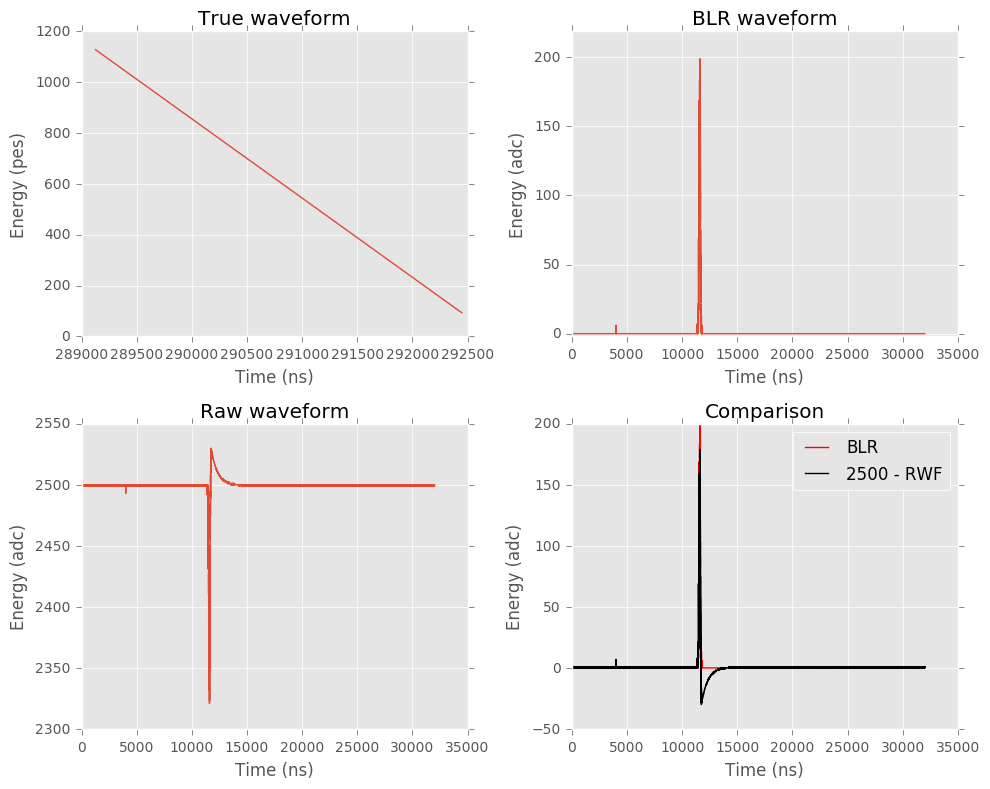

In [9]:
Tt, Te = tbl.read_wf(pmttwf,0,0)

fig, axes = plt.subplots(2,2)
axes[0,0].plot(Tt,Te)
axes[0,1].plot(pmtblr[0,0]);axes[0,1].set_ylim((-2,1.1*pmtblr[0,0].max()))
axes[1,0].plot(pmtrwf[0,0])
axes[1,1].plot(pmtblr[0,0],'r',label='BLR')
axes[1,1].plot(2500-pmtrwf[0,0],'k',label='2500 - RWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (pes)');axes[0,0].set_title('True waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Raw waveform')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the SiPMs TWF, RWF for event 0, SiPM *max*

SiPM with greatest peak is at index 331 with ID 6011.0


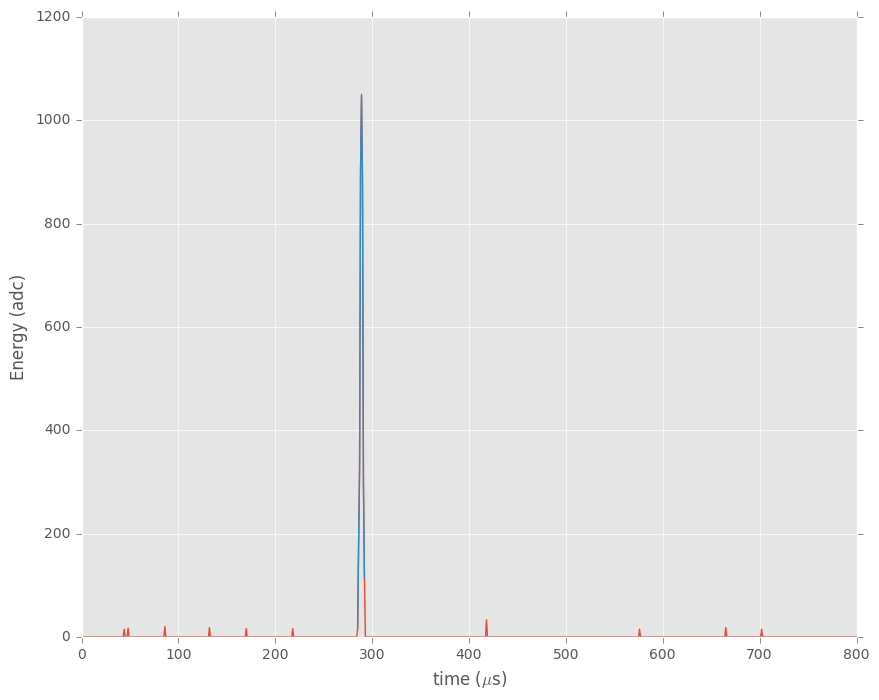

In [10]:
mpl.plot_best(sipmrwf,sipmtwf,sipmdf,0)

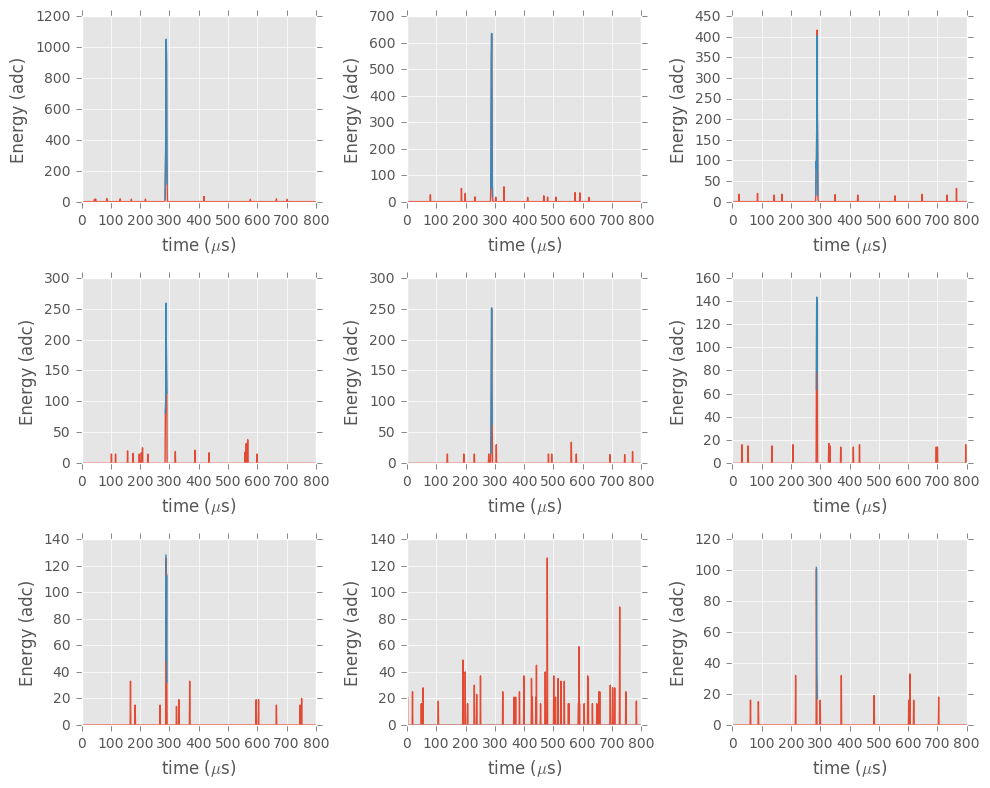

In [11]:
mpl.plot_best_group(sipmrwf,sipmtwf,sipmdf,0,9)

### Plot of the RWF, BLR and CWF for event 0 PMT 0:

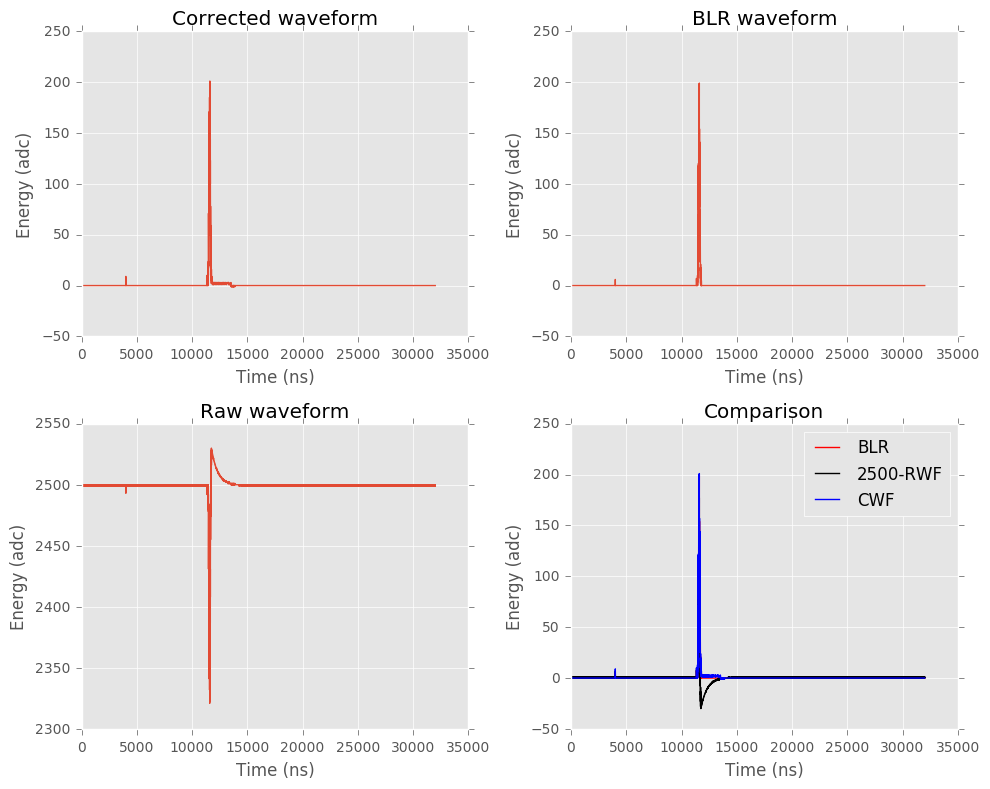

In [12]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(pmtcwf[0,0])
axes[0,1].plot(pmtblr[0,0])
axes[1,0].plot(pmtrwf[0,0])
axes[1,1].plot(pmtblr[0,0],'r',label='BLR')
axes[1,1].plot(2500-pmtrwf[0,0],'k',label='2500-RWF')
axes[1,1].plot(pmtcwf[0,0],'b',label='CWF')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (adc)');axes[0,0].set_title('Corrected waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (adc)');axes[0,1].set_title('BLR waveform');axes[0,1].set_ylim(axes[0,0].get_ylim())
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (adc)');axes[1,0].set_title('Raw waveform')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (adc)');axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the mau, pulse_on and wait_over variables for event 0

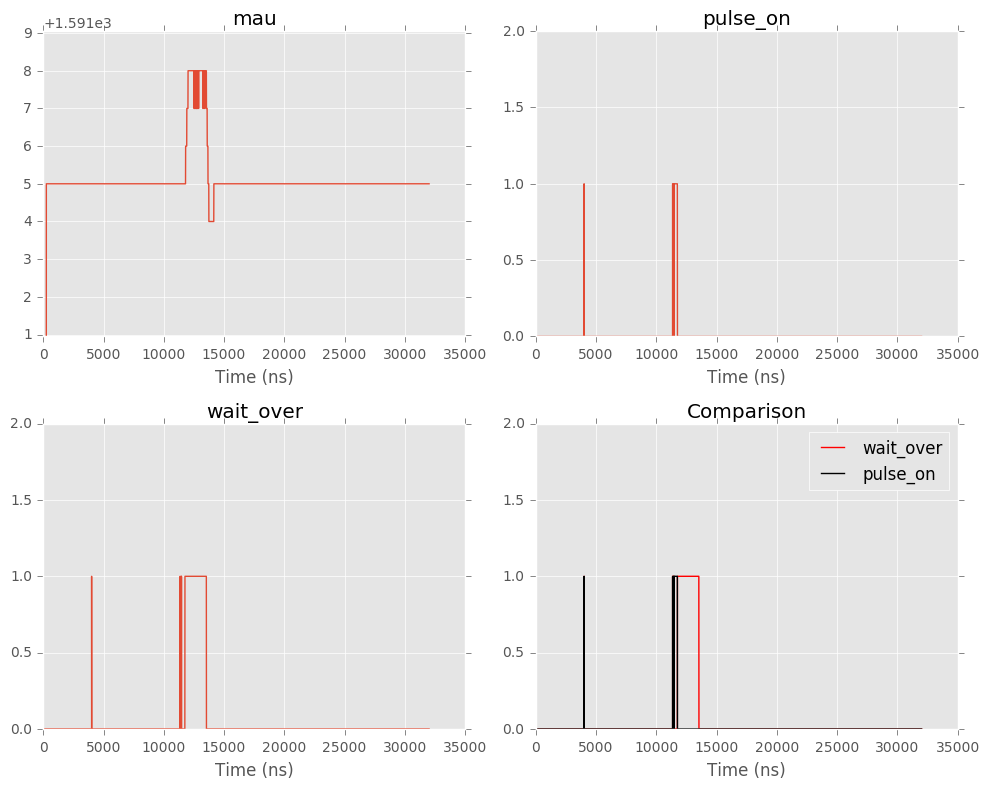

In [13]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(blrmau[0])
axes[0,1].plot(blrpulse[0])
axes[1,0].plot(blrwait[0])
axes[1,1].plot(blrwait[0],'r',label='wait_over')
axes[1,1].plot(blrpulse[0],'k',label='pulse_on')

avemau, stdmau = np.bincount(blrmau[0]).argmax(),np.std(blrmau[0])
mauwindow = avemau - 0.05*stdmau, avemau + 0.05*stdmau,
axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylim(mauwindow);axes[0,0].set_title('mau')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylim((0,2));axes[0,1].set_title('pulse_on')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylim((0,2));axes[1,0].set_title('wait_over')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylim((0,2));axes[1,1].set_title('Comparison')

axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the ZS CWF, and BLR for event 0 (PMT-summed):

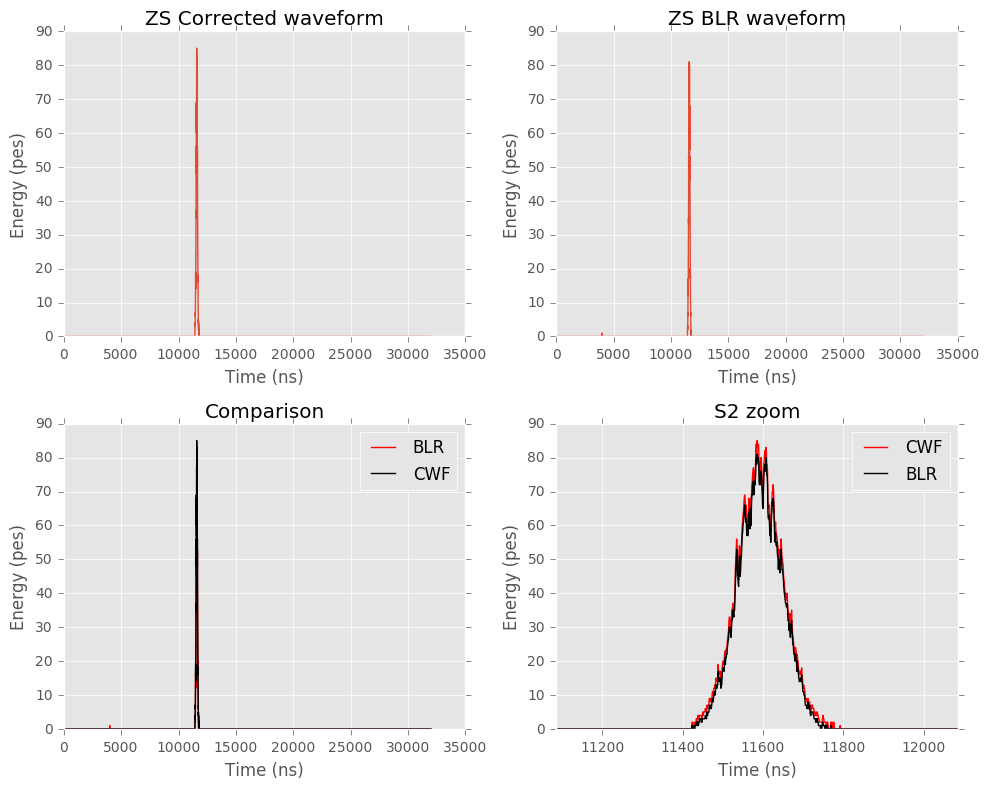

In [14]:
fig, axes = plt.subplots(2,2)
peak, window = np.argmax(pmtzswf[0,0]),500

axes[0,0].plot(pmtzswf[0,0])
axes[0,1].plot(blrzswf[0,0])
axes[1,0].plot(blrzswf[0,0],'r',label='BLR')
axes[1,0].plot(pmtzswf[0,0],'k',label='CWF')
axes[1,1].plot(pmtzswf[0,0],'r',label='CWF')
axes[1,1].plot(blrzswf[0,0],'k',label='BLR')

axes[0,0].set_xlabel('Time (ns)');axes[0,0].set_ylabel('Energy (pes)');axes[0,0].set_title('ZS Corrected waveform')
axes[0,1].set_xlabel('Time (ns)');axes[0,1].set_ylabel('Energy (pes)');axes[0,1].set_title('ZS BLR waveform')
axes[1,0].set_xlabel('Time (ns)');axes[1,0].set_ylabel('Energy (pes)');axes[1,0].set_title('Comparison')
axes[1,1].set_xlabel('Time (ns)');axes[1,1].set_ylabel('Energy (pes)');axes[1,1].set_title('S2 zoom')
axes[1,1].set_xlim((peak-window,peak+window))

axes[1,0].legend()
axes[1,1].legend()

fig.set_size_inches(10,8)
fig.tight_layout()

### Plot of the ZS SiPM WF for event 0:

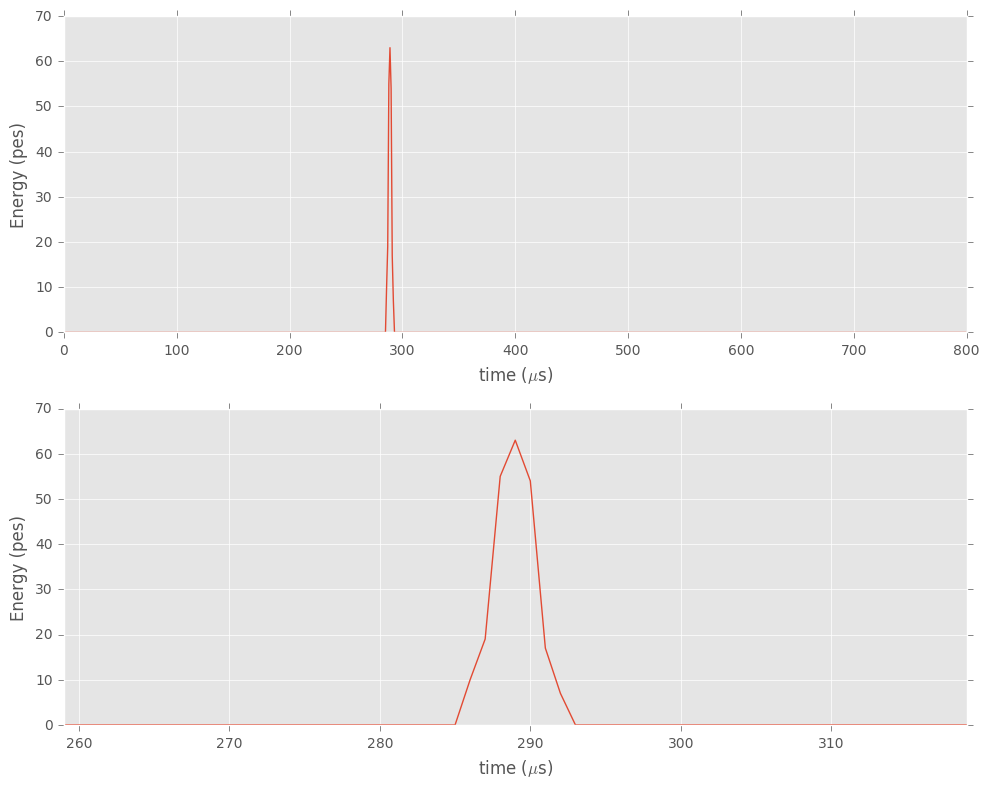

In [15]:
maxsipm = maxsipm = np.unravel_index(sipmzswf[0].argmax(),sipmzswf[0].shape)[0]
maxtime = np.argmax(sipmzswf[0,maxsipm])
wfrange = maxtime - 30,  maxtime + 30

fig, ax = plt.subplots(2)
ax[0].plot(sipmzswf[0,maxsipm])
ax[1].plot(sipmzswf[0,maxsipm]);ax[1].set_xlim(wfrange)

ax[0].set_xlabel('time ($\mu$s)');ax[0].set_ylabel('Energy (pes)')
ax[1].set_xlabel('time ($\mu$s)');ax[1].set_ylabel('Energy (pes)')

fig.set_size_inches(10,8)
fig.tight_layout()

### Statistical studies about energy: comparison between true and corrected

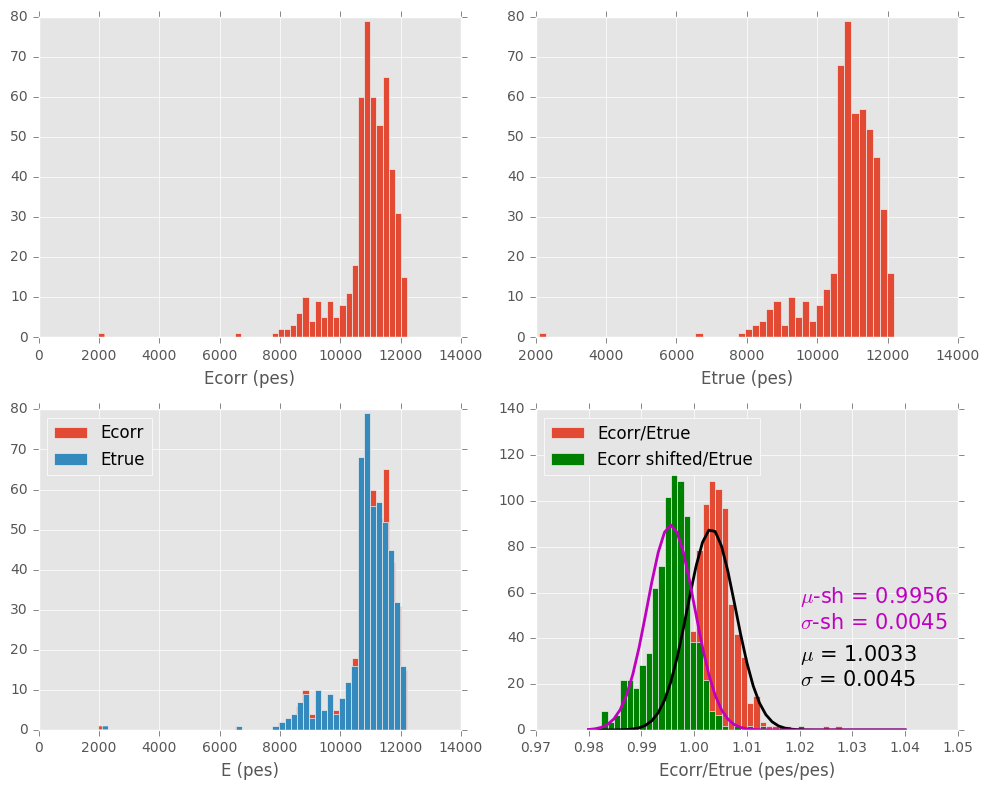

In [18]:
from scipy.stats import norm
import matplotlib.mlab as mlab

nevts = pmtrwf.shape[0]
nbins = 50
Etrue = np.empty(nevts)
Ecorr = np.empty(nevts)

for i in range(nevts):
    Ecorr[i] = np.sum(pmtzswf[i,0])
    Etrue[i] = tbl.read_wf_table(pmttwf,i).sum().sum(axis=1).ene_pes

c0,c1 = np.polyfit(Etrue,Ecorr,1)

Eratio = Ecorr/Etrue
EratioCorr = (Ecorr-c1)/Etrue

fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,8)
hcorr  = axes[0,0].hist(Ecorr,nbins)
htrue  = axes[0,1].hist(Etrue,nbins)
hcorr  = axes[1,0].hist(Ecorr,nbins,label='Ecorr')
htrue  = axes[1,0].hist(Etrue,nbins,label='Etrue')
axes[1,0].legend(loc='upper left')
hratio = axes[1,1].hist(Eratio,nbins,range=(0.98,1.04),normed=True,label='Ecorr/Etrue')
hratioCorr = axes[1,1].hist(EratioCorr,nbins,range=(0.98,1.04),normed=True,label='Ecorr shifted/Etrue',color='g')
axes[1,1].legend(loc='upper left')

axes[0,0].set_xlabel('Ecorr (pes)')
axes[0,1].set_xlabel('Etrue (pes)')
axes[1,0].set_xlabel('E (pes)')
axes[1,1].set_xlabel('Ecorr/Etrue (pes/pes)')


bins = hratio[1]
mu,sigma = norm.fit(Eratio[ (Eratio>0.98) & (Eratio<1.04) ])
y = mlab.normpdf( bins, mu, sigma)

binsC = hratioCorr[1]
muC,sigmaC = norm.fit(EratioCorr[ (EratioCorr>0.98) & (EratioCorr<1.04) ])
yC = mlab.normpdf( binsC, muC, sigmaC)

axes[1,1].text(1.02,20,'$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu,sigma),fontsize=15,color='k')
axes[1,1].text(1.02,45,'$\mu$-sh = {:.4f}\n$\sigma$-sh = {:.4f}'.format(muC,sigmaC),fontsize=15,color='m')

ratiof = axes[1,1].plot(bins, y, 'k-', linewidth=2)
ratiofC = axes[1,1].plot(binsC, yC, 'm-', linewidth=2)

plt.tight_layout()


### Statistical studies about energy: comparison between BLR and corrected

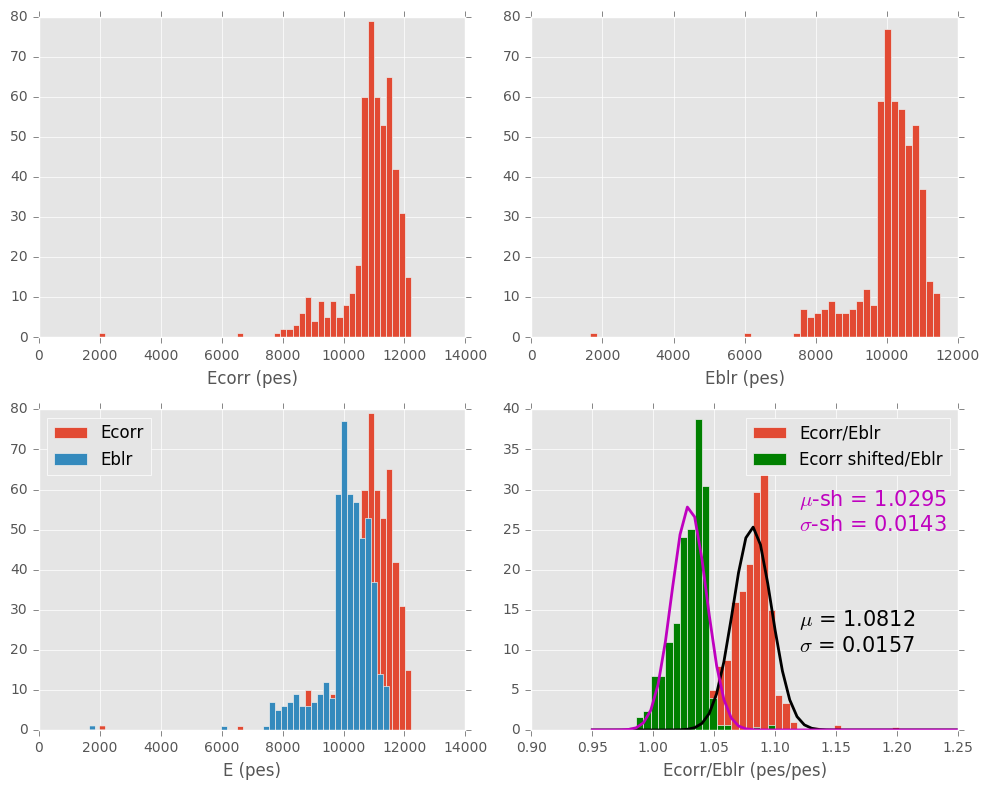

In [17]:
from scipy.stats import norm
import matplotlib.mlab as mlab

ratiorange = [0.95,1.25]

nevts = pmtrwf.shape[0]
nbins = 50
Etrue = np.empty(nevts)
Ecorr = np.empty(nevts)

for i in range(nevts):
    Ecorr[i] = np.sum(pmtzswf[i,0])
    Etrue[i] = np.sum(blrzswf[i,0])

c0,c1 = np.polyfit(Etrue,Ecorr,1)

Eratio = Ecorr/Etrue
EratioCorr = (Ecorr-c1)/Etrue

fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,8)
hcorr  = axes[0,0].hist(Ecorr,nbins)
htrue  = axes[0,1].hist(Etrue,nbins)
hcorr  = axes[1,0].hist(Ecorr,nbins,label='Ecorr')
htrue  = axes[1,0].hist(Etrue,nbins,label='Eblr')
axes[1,0].legend(loc='upper left')
hratio = axes[1,1].hist(Eratio,nbins,range=ratiorange,normed=True,label='Ecorr/Eblr')
hratioCorr = axes[1,1].hist(EratioCorr,nbins,range=ratiorange,normed=True,label='Ecorr shifted/Eblr',color='g')
axes[1,1].legend()

axes[0,0].set_xlabel('Ecorr (pes)')
axes[0,1].set_xlabel('Eblr (pes)')
axes[1,0].set_xlabel('E (pes)')
axes[1,1].set_xlabel('Ecorr/Eblr (pes/pes)')

bins = hratio[1]
mu,sigma = norm.fit(Eratio[ (Eratio>ratiorange[0]) & (Eratio<ratiorange[1]) ])
y = mlab.normpdf( bins, mu, sigma)

binsC = hratioCorr[1]
muC,sigmaC = norm.fit(EratioCorr[ (EratioCorr>ratiorange[0]) & (EratioCorr<ratiorange[1]) ])
yC = mlab.normpdf( binsC, muC, sigmaC)

axes[1,1].text(1.12,10,'$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu,sigma),fontsize=15,color='k')
axes[1,1].text(1.12,25,'$\mu$-sh = {:.4f}\n$\sigma$-sh = {:.4f}'.format(muC,sigmaC),fontsize=15,color='m')

ratiof = axes[1,1].plot(bins, y, 'k-', linewidth=2)
ratiofC = axes[1,1].plot(binsC, yC, 'm-', linewidth=2)

plt.tight_layout()
